In [94]:
import torch
from torch import nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
import time
import numpy as np
from IPython import display

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        
        out = self(images)
        out.to(device)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        out = self(images)
        out.to(device)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [124]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb, return_all_layers=False):
        return self.network(xb)   

In [125]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [126]:
from torchvision.datasets import CIFAR10
cifar10_data = CIFAR10('.', download=True, transform=ToTensor())
cifar10_classes = cifar10_data.classes

Files already downloaded and verified


In [100]:
cifar10_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [127]:
random_seed = 42
torch.manual_seed(random_seed)

al_size = 10000
train_val_size = len(cifar10_data) - al_size

val_size = 35000
train_size = train_val_size - val_size

train_ds, val_ds, al_ds = random_split(cifar10_data, [train_size, val_size, al_size])
len(train_ds), len(val_ds), len(al_ds)

(5000, 35000, 10000)

In [128]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [129]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

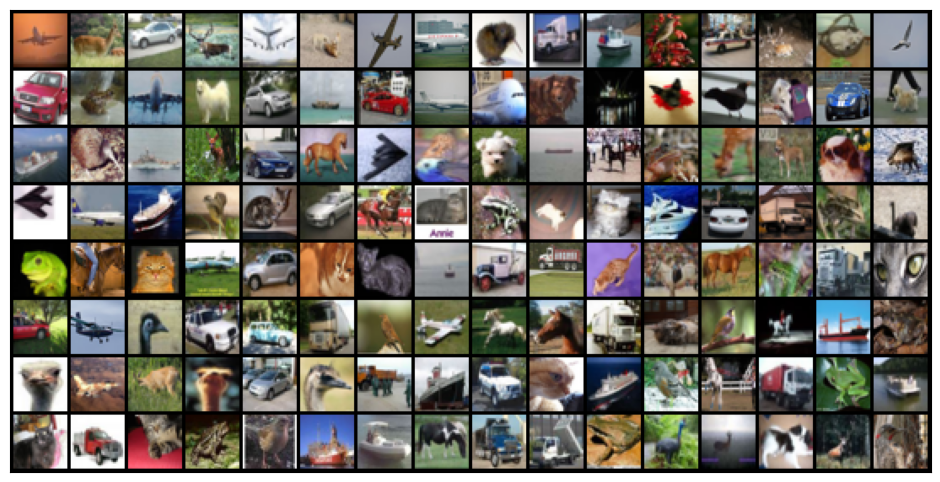

In [104]:
show_batch(train_dl)

In [105]:
from torchviz import make_dot

X, y = next(iter(train_dl))
model = Cifar10CnnModel()
y = model(X)
make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [130]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [131]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0196,  0.0412, -0.0259, -0.0372,  0.0458, -0.0270, -0.0139,  0.0324,
         0.0289,  0.0189], grad_fn=<SelectBackward0>)


In [132]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [133]:
device

'cuda'

In [134]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [135]:
model = to_device(Cifar10CnnModel(), device)

In [112]:
evaluate(model, val_dl)

{'val_loss': 2.3028783798217773, 'val_acc': 0.10013314336538315}

In [136]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

history_train = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.2547, val_loss: 2.2384, val_acc: 0.1973
Epoch [1], train_loss: 2.0476, val_loss: 1.9859, val_acc: 0.2778
Epoch [2], train_loss: 1.9332, val_loss: 1.8900, val_acc: 0.2887
Epoch [3], train_loss: 1.7627, val_loss: 1.8024, val_acc: 0.3280
Epoch [4], train_loss: 1.6756, val_loss: 1.7420, val_acc: 0.3425
Epoch [5], train_loss: 1.6205, val_loss: 1.6476, val_acc: 0.3901
Epoch [6], train_loss: 1.5074, val_loss: 1.5536, val_acc: 0.4273
Epoch [7], train_loss: 1.4338, val_loss: 1.5711, val_acc: 0.4199
Epoch [8], train_loss: 1.3554, val_loss: 1.5483, val_acc: 0.4458
Epoch [9], train_loss: 1.2318, val_loss: 1.5665, val_acc: 0.4598


In [137]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Accuracy'])
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

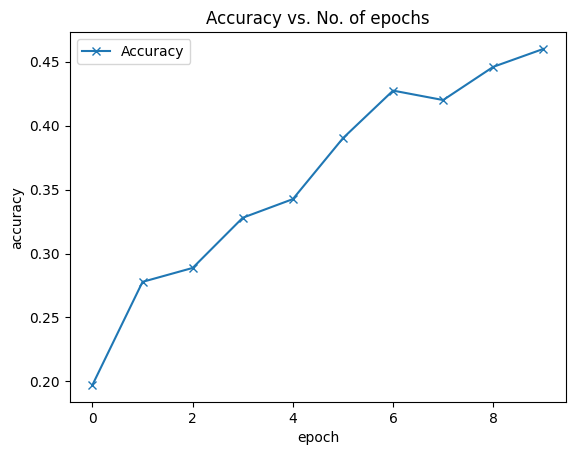

In [138]:
plot_accuracies(history_train)

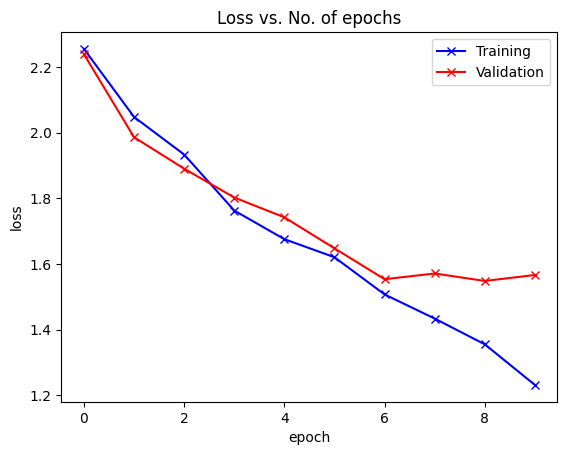

In [139]:
plot_losses(history_train)

In [140]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]
        return image
    

class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.data = list(self.base_dataset)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def append(self, item):
        self.data.append(item)

In [141]:
train_ds = CustomCIFAR10Dataset(train_ds)
val_ds = CustomCIFAR10Dataset(val_ds)
unlabeled_ds = UnlabeledDataset(al_ds)
len(train_ds), len(val_ds), len(unlabeled_ds)

(5000, 35000, 10000)

In [142]:
import math
from random import shuffle

class UncertaintySampling():
    def __init__(self, verbose=False):
        self.verbose = verbose
    

    def least_confidence(self, prob_dist, sorted=False):
        """ 
        Returns the uncertainty score of an array using
        least confidence sampling in a 0-1 range where 1 is the most uncertain
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
                    
        Keyword arguments:
            prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        if sorted:
            simple_least_conf = prob_dist.data[0] # most confident prediction
        else:
            simple_least_conf = torch.max(prob_dist) # most confident prediction
                    
        num_labels = prob_dist.numel() # number of labels
         
        normalized_least_conf = (1 - simple_least_conf) * (num_labels / (num_labels -1))
        
        return normalized_least_conf.item()
    
    
    def margin_confidence(self, prob_dist, sorted=False):
        """ 
        Returns the uncertainty score of a probability distribution using
        margin of confidence sampling in a 0-1 range where 1 is the most uncertain
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
            
        Keyword arguments:
            prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        if not sorted:
            prob_dist, _ = torch.sort(prob_dist, descending=True) # sort probs so largest is first
        
        difference = (prob_dist.data[0] - prob_dist.data[1]) # difference between top two props
        margin_conf = 1 - difference 
        
        return margin_conf.item()
        
    
    def ratio_confidence(self, prob_dist, sorted=False):
        """ 
        Returns the uncertainty score of a probability distribution using
        ratio of confidence sampling in a 0-1 range where 1 is the most uncertain
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
                    
        Keyword arguments:
            prob_dist --  pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        if not sorted:
            prob_dist, _ = torch.sort(prob_dist, descending=True) # sort probs so largest is first        
            
        ratio_conf = prob_dist.data[1] / prob_dist.data[0] # ratio between top two props
        
        return ratio_conf.item()
    
    
    def entropy_based(self, prob_dist):
        """ 
        Returns the uncertainty score of a probability distribution using
        entropy 
        
        Assumes probability distribution is a pytorch tensor, like: 
            tensor([0.0321, 0.6439, 0.0871, 0.2369])
                    
        Keyword arguments:
            prob_dist -- a pytorch tensor of real numbers between 0 and 1 that total to 1.0
            sorted -- if the probability distribution is pre-sorted from largest to smallest
        """
        log_probs = prob_dist * torch.log2(prob_dist) # multiply each probability by its base 2 log
        raw_entropy = 0 - torch.sum(log_probs)
    
        normalized_entropy = raw_entropy / math.log2(prob_dist.numel())
        
        return normalized_entropy.item()

In [144]:
def query_uncertain_samples(model, unlabeled_dl, labeled_img = [], num_samples=1000):
    uncertainty_sampling = UncertaintySampling()
    model.eval()
    uncertainties = []
    images_to_label = []

    with torch.no_grad():
        for batch in unlabeled_dl:
            images = batch.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            uncertainty_scores = [uncertainty_sampling.least_confidence(prob_dist = prob) for prob in probs]
            uncertainties.extend(uncertainty_scores)
            images_to_label.extend(images)

            if len(uncertainties) >= num_samples:
                break
    
    # Remove labeled images from images_to_label
    images_to_label_filtered = []
    for img in images_to_label:
        img_cpu = img.cpu().numpy()
        if not any(np.array_equal(img_cpu, labeled_img_item.cpu().numpy()) for labeled_img_item in labeled_img):
            images_to_label_filtered.append(img)


    sorted_indices = sorted(range(len(uncertainties)), key=lambda i: uncertainties[i])

    # Ensure num_samples does not exceed the available images
    num_samples = min(num_samples, len(images_to_label_filtered))

    selected_images = [images_to_label_filtered[i] for i in sorted_indices[:num_samples]]

    return selected_images

def active_learning_train(num_epochs, lr, model, train_ds, train_dl, val_dl, unlabeled_dl, opt_func):
    history = []
    labeled_img = []
    num_queries = 2  # Number of samples to manually label in each epoch

    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(num_epochs):
        
        selected_images = query_uncertain_samples(model, unlabeled_dl, labeled_img = labeled_img, num_samples=num_queries)

        for i in range(num_queries):
            display.clear_output(wait=True)
            
            query_inst_cpu = selected_images[i].cpu()
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title('Image to label')
            plt.imshow(query_inst_cpu.squeeze().permute(1, 2, 0).numpy())
            plt.show()

            for idx, class_name in enumerate(cifar10_classes):
                print(f'{idx} - {class_name}')
            time.sleep(0.4)
            
            valid_input = False
            while not valid_input:
                try:
                    print("Which class is this? (Enter a number from 0 to 9). Enter '1111' to exit")
                    user_input = int(input())
                    if user_input >= 0 and user_input <= 9:
                        valid_input = True
                    elif user_input == 1111:
                        break
                    else:
                        print("Invalid input. Please enter a number from 0 to 9.")
                except ValueError:
                    print("Invalid input. Please enter a valid integer.")

            # Create label tensor
            y_new = user_input

            labeled_img.append(query_inst_cpu)
            train_ds.append((query_inst_cpu, y_new))
            
        train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) 
        
        # Training Phase
        model.train()
        train_losses = []

        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        history.append(result)

        if epoch > 0:
            plt.plot(range(epoch + 1), [h['val_acc'] for h in history[:epoch + 1]], marker='o')
            plt.xlabel('Epoch')
            plt.ylabel('Validation Accuracy')
            plt.show()
        
        model.epoch_end(epoch, result)
    
    return history

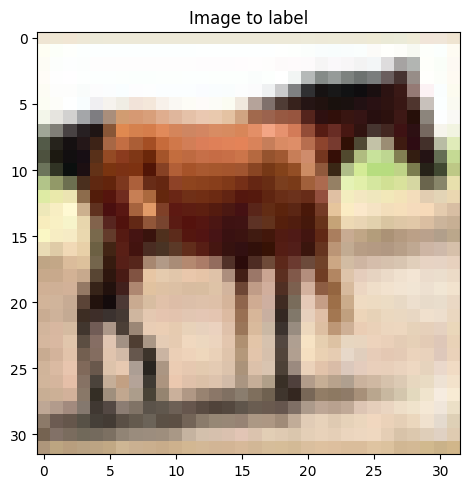

0 - airplane
1 - automobile
2 - bird
3 - cat
4 - deer
5 - dog
6 - frog
7 - horse
8 - ship
9 - truck
Which class is this? (Enter a number from 0 to 9). Enter '1111' to exit


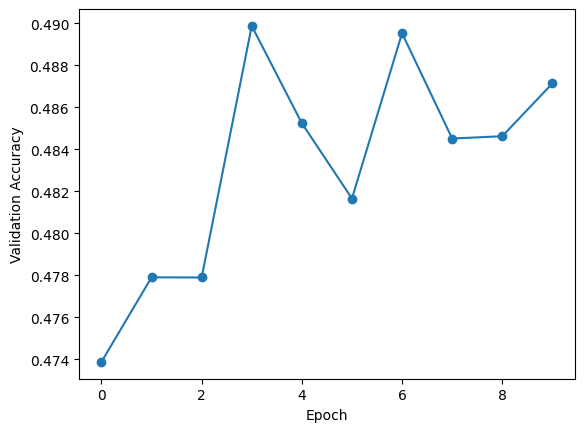

Epoch [9], train_loss: 0.1695, val_loss: 3.2765, val_acc: 0.4871


In [145]:
unlabeled_dl = DataLoader(unlabeled_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size = batch_size * 2, shuffle=True, num_workers=4, pin_memory=True)

unlabeled_dl = DeviceDataLoader(unlabeled_dl, device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

num_epochs = 10
lr = 0.001

#history = ct_active_learning_train(model, train_ds, train_dl, val_dl, unlabeled_dl, opt_func = torch.optim.Adam, max_iterations=10, num_queries = 4)

history = active_learning_train(num_epochs, lr, model, train_ds, train_dl, val_dl, unlabeled_dl, opt_func = torch.optim.Adam)

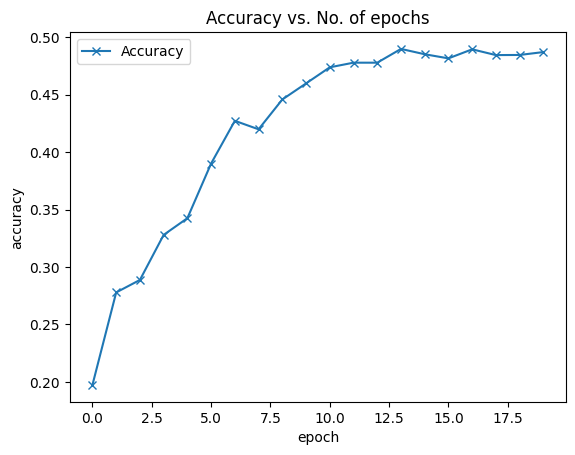

In [146]:
all_history = history_train + history

plot_accuracies(all_history)

Do: {'val_loss': 1.5708472728729248, 'val_acc': 0.43455326557159424, 'train_loss': 1.3669363260269165}, Posle: {'val_loss': 2.170339822769165, 'val_acc': 0.5035727620124817, 'train_loss': 0.4466707706451416} 


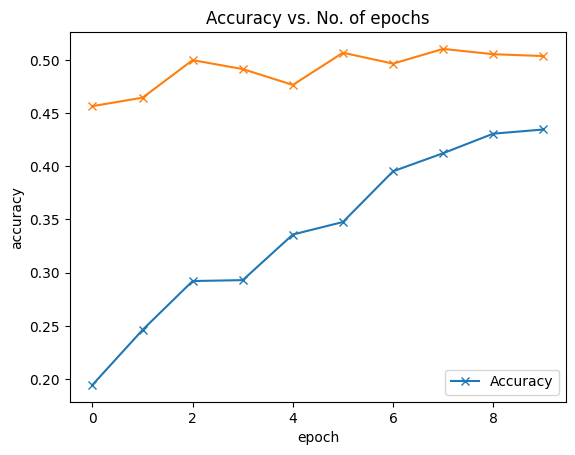

In [123]:
print(f'Do: {history_train[-1]}, Posle: {history[-1]} ')

plot_accuracies(history_train)
plot_accuracies(history)

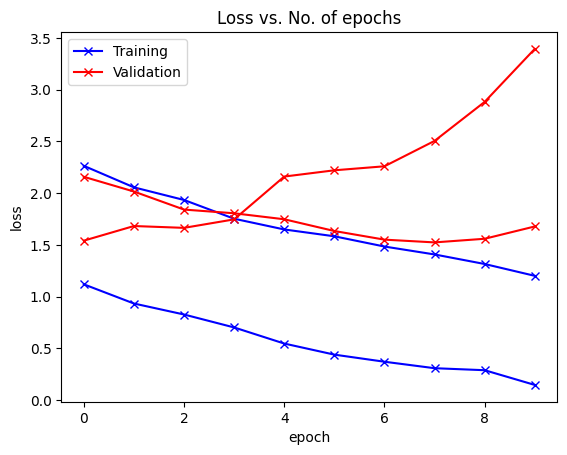

In [77]:
plot_losses(history_train)
plot_losses(history)

In [90]:
import random

i = random.randint(0, len(al_ds))

test_ds = al_ds[i]
test_ds

(tensor([[[0.2627, 0.3725, 0.3647,  ..., 0.1255, 0.0863, 0.0745],
          [0.2902, 0.4353, 0.3451,  ..., 0.1647, 0.0941, 0.0549],
          [0.2588, 0.4078, 0.3373,  ..., 0.1255, 0.0863, 0.0667],
          ...,
          [0.7137, 0.6824, 0.6980,  ..., 0.4863, 0.6078, 0.6980],
          [0.7137, 0.6863, 0.7059,  ..., 0.3294, 0.3725, 0.4863],
          [0.7294, 0.7137, 0.7176,  ..., 0.4275, 0.3412, 0.3373]],
 
         [[0.3373, 0.4549, 0.4549,  ..., 0.1765, 0.1255, 0.0902],
          [0.3686, 0.5216, 0.4353,  ..., 0.2157, 0.1333, 0.0706],
          [0.3373, 0.4941, 0.4275,  ..., 0.1765, 0.1255, 0.0824],
          ...,
          [0.6824, 0.6510, 0.6667,  ..., 0.4706, 0.5804, 0.6588],
          [0.6824, 0.6549, 0.6745,  ..., 0.3333, 0.3725, 0.4784],
          [0.6980, 0.6824, 0.6863,  ..., 0.4392, 0.3529, 0.3529]],
 
         [[0.5137, 0.6353, 0.6471,  ..., 0.1529, 0.1176, 0.1059],
          [0.5294, 0.6863, 0.6118,  ..., 0.1922, 0.1255, 0.0863],
          [0.4863, 0.6510, 0.5922,  ...,

In [36]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return cifar10_data.classes[preds[0].item()]

Label: horse , Predicted: horse


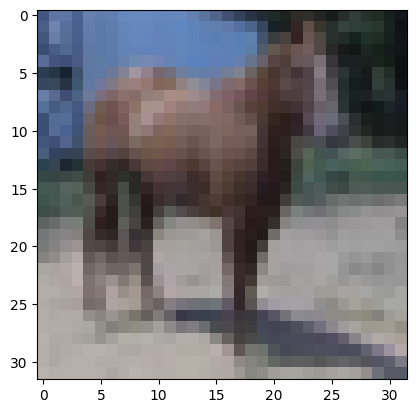

In [91]:
img, label = test_ds
plt.imshow(img.permute(1, 2, 0))
print('Label:', cifar10_data.classes[label], ', Predicted:', predict_image(img, model))